In [1]:
!pip install -q torchinfo

In [2]:
import torch
from torch import nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
import torchinfo
import matplotlib.pyplot as plt
from fastai.vision.all import *
from tqdm.auto import tqdm

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Data Prep

In [4]:
path = untar_data(URLs.IMAGENETTE_160)
path.ls()

(#4) [Path('/storage/data/imagenette2-160/train'),Path('/storage/data/imagenette2-160/val'),Path('/storage/data/imagenette2-160/.DS_Store'),Path('/storage/data/imagenette2-160/noisy_imagenette.csv')]

In [5]:
train_dir = path / 'train'
test_dir = path / 'val'

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.RandomHorizontalFlip(p=0.5)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [7]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

In [8]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [9]:
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

In [10]:
train_data.classes = [lbl_dict[i] for i in train_data.classes]

In [11]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [12]:
class_names = train_data.classes
class_names

['tench',
 'English springer',
 'cassette player',
 'chain saw',
 'church',
 'French horn',
 'garbage truck',
 'gas pump',
 'golf ball',
 'parachute']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

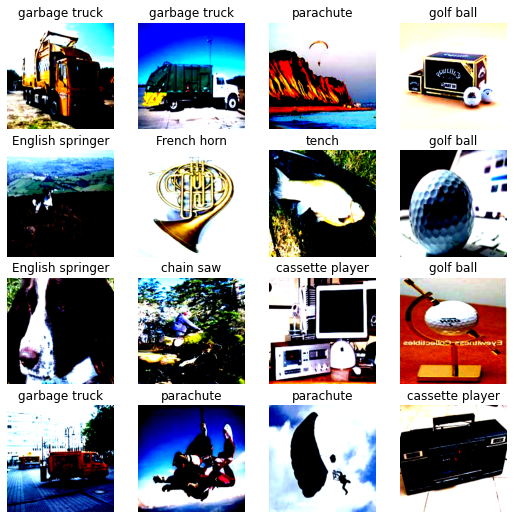

In [13]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(class_names[label])
    plt.axis(False)

## Resnet Model

### Basic Residual Block

In [14]:
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2e(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        identity = x
        
        out = self.relu(self.bn1(self.conv1(x)))
        
        out = self.bn2(self.conv2(out))
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        
        return out

### Bottleneck Block

In [15]:
class Bottleneck(nn.Module):
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * Bottleneck.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * Bottleneck.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        identity = x
        
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        
        if self.downsample is not None:
            identity = self.downsample(identity)
            
        out += identity
        out = self.relu(out)
        
        return out

### Resnet Architecture

In [16]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes):
        super().__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        downsample = None
        
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, stride=stride, kernel_size=1),
                nn.BatchNorm2d(out_channels * block.expansion)
            )
            
        layers = []
        layers.append(
            block(self.in_channels, out_channels, stride=stride, downsample=downsample)
        )
        
        self.in_channels = out_channels * block.expansion
        
        for _ in range(1, num_blocks):
            layers.append(
                block(self.in_channels, out_channels)
            )
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        
        x = self.layer4(self.layer3(self.layer2(self.layer1(x))))
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x

In [17]:
def resnet50(): return ResNet(block=Bottleneck, layers=[3, 4, 6, 3], num_classes=10)

In [18]:
model = resnet50()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, ep

## Training Part

In [19]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(params=model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(opt, base_lr=0.001, max_lr=0.1)

In [20]:
def train_step(model, dataloader, loss_fn, optimizer, scheduler=None, device=device):
    model.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
        
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    if scheduler is not None: scheduler.step(loss)
    
    return train_loss, train_acc

In [21]:
def test_step(model, dataloader, loss_fn, device=device):
    model.eval()
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            
            test_pred_logits = model(X)
            
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))
            
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    
    return test_loss, test_acc

In [22]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, scheduler=None, device=device):
    results = {"train_loss": [],
               "train_acc" : [],
               "test_loss" : [],
               "test_acc"  : []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, dataloader=train_dataloader,
                                           loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler, device=device)
        test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn, device=device)
        
        print(f"Epoch: {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
        
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)
        
    return results

In [23]:
results = train(model, train_dataloader, test_dataloader, opt, loss_fn, epochs=20, scheduler=scheduler, device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

/root/mambaforge/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1 | Train Loss: 2.0995 | Train Acc: 0.2710 | Test Loss: 1.9689 | Test Acc: 0.3655
Epoch: 2 | Train Loss: 1.6372 | Train Acc: 0.4541 | Test Loss: 1.4458 | Test Acc: 0.5334
Epoch: 3 | Train Loss: 1.3226 | Train Acc: 0.5646 | Test Loss: 1.6395 | Test Acc: 0.5351
Epoch: 4 | Train Loss: 1.1301 | Train Acc: 0.6374 | Test Loss: 1.3063 | Test Acc: 0.5899
Epoch: 5 | Train Loss: 1.0219 | Train Acc: 0.6717 | Test Loss: 1.1668 | Test Acc: 0.6446
Epoch: 6 | Train Loss: 0.8618 | Train Acc: 0.7235 | Test Loss: 1.0758 | Test Acc: 0.6673
Epoch: 7 | Train Loss: 0.7890 | Train Acc: 0.7407 | Test Loss: 0.9935 | Test Acc: 0.7008
Epoch: 8 | Train Loss: 0.6874 | Train Acc: 0.7742 | Test Loss: 0.9654 | Test Acc: 0.7054
Epoch: 9 | Train Loss: 0.6135 | Train Acc: 0.7991 | Test Loss: 1.0102 | Test Acc: 0.7078
Epoch: 10 | Train Loss: 0.5504 | Train Acc: 0.8151 | Test Loss: 0.8588 | Test Acc: 0.7386
Epoch: 11 | Train Loss: 0.4780 | Train Acc: 0.8433 | Test Loss: 1.2965 | Test Acc: 0.6600
Epoch: 12 | Train L

### Visualizing the losses

In [24]:
def plot_loss_curves(results):
    loss = results['train_loss']
    test_loss = results['test_loss']
    
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']
    
    epochs = range(len(results['train_loss']))
    
    plt.figure(figsize=(15, 7))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_acc')
    plt.plot(epochs, test_accuracy, label='test_acc')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

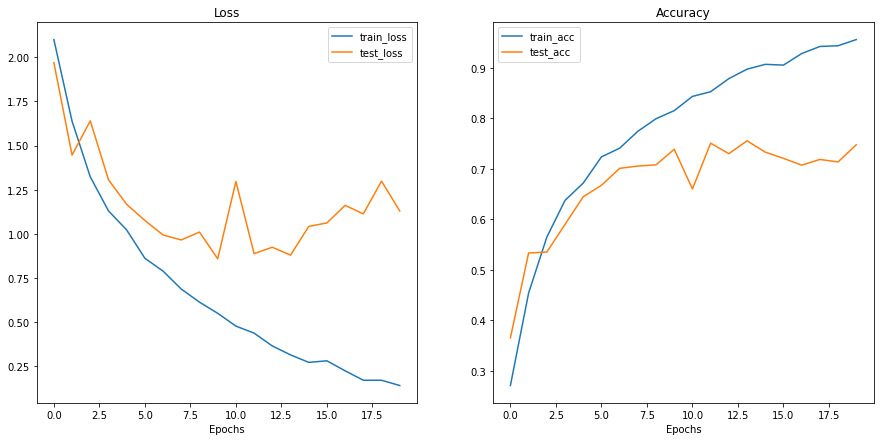

In [25]:
plot_loss_curves(results)

## Checking the Model Predictions

In [26]:
def make_preds(model, data, device=device):
    pred_probs = []
    model.eval()
    
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
            
    return torch.stack(pred_probs)

In [27]:
import random
test_samples, test_labels = [], []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
    
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([3, 224, 224])
Test sample label: 8 (golf ball)


In [28]:
pred_probs = make_preds(model=model, data=test_samples)
pred_probs[:2]

tensor([[9.8838e-01, 1.2444e-04, 4.0026e-04, 1.9458e-04, 5.2973e-04, 6.0682e-03,
         8.3526e-06, 9.6704e-05, 4.1622e-03, 3.0558e-05],
        [6.1281e-03, 1.1538e-03, 9.1284e-06, 3.3065e-01, 8.1930e-02, 2.0995e-01,
         2.0395e-05, 3.6986e-01, 3.5922e-05, 2.5796e-04]])

In [29]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([0, 7, 2, 0, 2, 0, 1, 7, 4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


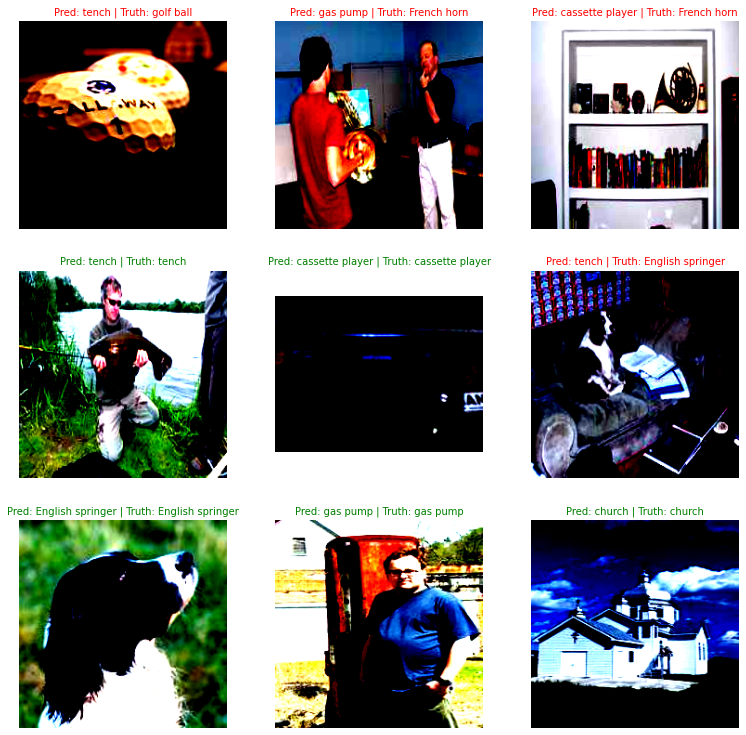

In [30]:
plt.figure(figsize=(13,13))
nrows, ncols = 3, 3

for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.permute(1, 2, 0))
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c='g')
    else:
        plt.title(title_text, fontsize=10, c='r')
    plt.axis(False)

### Confusion Matrix

In [31]:
!pip install -q torchmetrics -U mlxtend

In [32]:
from tqdm.auto import tqdm

y_preds = []
model.eval()

with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc='Making Predictions'):
        X, y = X.to(device), y.to(device)
        y_logit = model(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making Predictions:   0%|          | 0/123 [00:01<?, ?it/s]

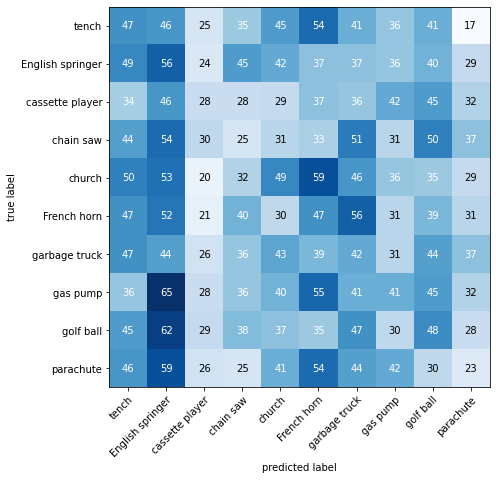

In [33]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=torch.Tensor(test_data.targets))

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=class_names, figsize=(10, 7))